In [133]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
from pathlib import Path
print(str(Path().resolve().parent))
sys.path.append(str(Path().resolve().parent))

import os
import h5py
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from typing import List, Dict, Union, Tuple, Optional
from pathlib import Path

from Data.data_class import plot_electron_spectrogram
from data_loader import MagnetotailDataset
from double_transformer import DoubleTransformer
from double_autoencoder import DoubleAutoencoder

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
C:\Users\ianma\OneDrive\Documents\Thesis\Magnetotail-Boundary-with-ML


In [2]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA")

2.2.2
12.1
True
NVIDIA GeForce RTX 3070 Ti


In [79]:
# TRAINING DATASET
file_path = Path('..') / "Data" / "training_data" / "test.h5"
abs_file_path = file_path.resolve()

# Create dataset
dataset = MagnetotailDataset(abs_file_path)


In [110]:
dataset.get_session_info()

[{'id': 'session_0000',
  'start_time': '2011-08-14 00:00:00',
  'end_time': '2011-08-15 23:59:00',
  'num_timestamps': 280,
  'variables': ['B_electron_avgtemp',
   'B_electron_density',
   'B_electron_eflux',
   'B_electron_velocity_gsm',
   'B_electron_vthermal',
   'B_ion_avgtemp',
   'B_ion_density',
   'B_ion_eflux',
   'B_ion_velocity_gsm',
   'B_ion_vthermal',
   'B_magnetic_field_gsm',
   'times']},
 {'id': 'session_0001',
  'start_time': '2011-11-12 00:00:00',
  'end_time': '2011-11-14 23:59:00',
  'num_timestamps': 406,
  'variables': ['B_electron_avgtemp',
   'B_electron_density',
   'B_electron_eflux',
   'B_electron_velocity_gsm',
   'B_electron_vthermal',
   'B_ion_avgtemp',
   'B_ion_density',
   'B_ion_eflux',
   'B_ion_velocity_gsm',
   'B_ion_vthermal',
   'B_magnetic_field_gsm',
   'times']},
 {'id': 'session_0002',
  'start_time': '2011-08-16 00:00:00',
  'end_time': '2011-08-18 00:00:00',
  'num_timestamps': 314,
  'variables': ['B_electron_avgtemp',
   'B_electro

In [4]:
# TESTING DATASET
file_path = Path('..') / "Data" / "testing_data" / "test.h5"
abs_file_path = file_path.resolve()

# Create dataset
testing_dataset = MagnetotailDataset(abs_file_path)

In [111]:
# Create a list of cutoff times for training
initial_cutoff_list = ['2011-08-14 22:50:00', 
                       '2011-11-12 05:40:00',
                       '2011-11-13 01:00:00',
                       '2011-11-13 22:00:00',
                       '2011-08-17 08:00:00',
                       '2011-08-16 01:10:00',
                       '2011-09-13 17:00:00',
                       '2011-09-14 13:15:00',
                       '2011-09-14 23:00:00',
                       '2012-02-09 11:00:00',
                       '2012-05-03 23:00:00', 
                       '2012-11-30 10:30:00',
                       ]
final_cutoff_list = ['2011-08-15 18:30:00',
                     '2011-11-12 06:40:00',
                     '2011-11-13 04:30:00',
                     '2011-11-13 23:30:00',
                     '2011-08-17 09:00:00',
                     '2011-08-16 02:30:00',
                     '2011-09-13 21:00:00',
                     '2011-09-14 14:15:00',
                     '2011-09-15 00:30:00',
                     '2012-02-09 14:00:00',
                     '2012-05-04 07:00:00',
                     '2012-11-30 12:00:00',
                     ]


# Assing the trainable times to the dataset
dataset.exclude_time_ranges(initial_cutoffs=initial_cutoff_list,
                           final_cutoffs=final_cutoff_list
                           )
dataset.set_trainable_samples()


{'section_000': {'session_id': ['session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
   'session_0000',
  

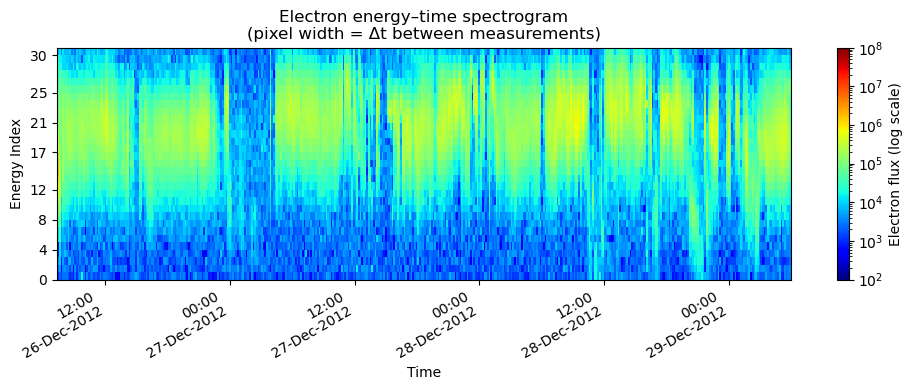

In [112]:
dataset.set_regions_for_sections()

In [129]:
# Get the trainable samples from the dataset
train_samples = dataset.get_trainable_samples()

# Define how many time steps to use for the input
timestamps = 4

# Initialize the autoencoder
MAE_transformer = DoubleTransformer(
    input_dim=31, 
    timestamps=timestamps, 
    d_model=256, 
    nhead=8, 
    num_encoder_layers=6,            
    num_decoder_layers=6, 
    dim_feedforward=512, 
    mask_ratio=0.4
    )

autoencoder = DoubleAutoencoder(hidden_layer_1=16, hidden_layer_2=32, hidden_layer_3=32,  latent_dim=32, timestamps=timestamps)

In [131]:
MAE_transformer.fit(train_samples, epochs=20, batch_size=512, learning_rate=0.001)

Epoch [1/20], Loss: 0.4574, Test Loss: 0.2199
Epoch [2/20], Loss: 0.2015, Test Loss: 0.1955
Epoch [3/20], Loss: 0.1799, Test Loss: 0.1746
Epoch [4/20], Loss: 0.1708, Test Loss: 0.1695
Epoch [5/20], Loss: 0.1576, Test Loss: 0.1586
Epoch [6/20], Loss: 0.1511, Test Loss: 0.1571
Epoch [7/20], Loss: 0.1462, Test Loss: 0.1496
Epoch [8/20], Loss: 0.1416, Test Loss: 0.1458
Epoch [9/20], Loss: 0.1341, Test Loss: 0.1305
Epoch [10/20], Loss: 0.1163, Test Loss: 0.1040
Epoch [11/20], Loss: 0.0943, Test Loss: 0.1014
Epoch [12/20], Loss: 0.1058, Test Loss: 0.0963
Epoch [13/20], Loss: 0.0920, Test Loss: 0.0925
Epoch [14/20], Loss: 0.0826, Test Loss: 0.0793
Epoch [15/20], Loss: 0.0760, Test Loss: 0.0767
Epoch [16/20], Loss: 0.0731, Test Loss: 0.0727
Epoch [17/20], Loss: 0.0714, Test Loss: 0.0727
Epoch [18/20], Loss: 0.0708, Test Loss: 0.0721
Epoch [19/20], Loss: 0.0697, Test Loss: 0.0710
Epoch [20/20], Loss: 0.0692, Test Loss: 0.0712
Epoch [1/20], Loss: 1.6156, Test Loss: 0.3648
Epoch [2/20], Loss: 0.3

In [119]:
trainable_samples = dataset.get_trainable_samples()

In [9]:
test_samples = testing_dataset.get_trainable_samples()

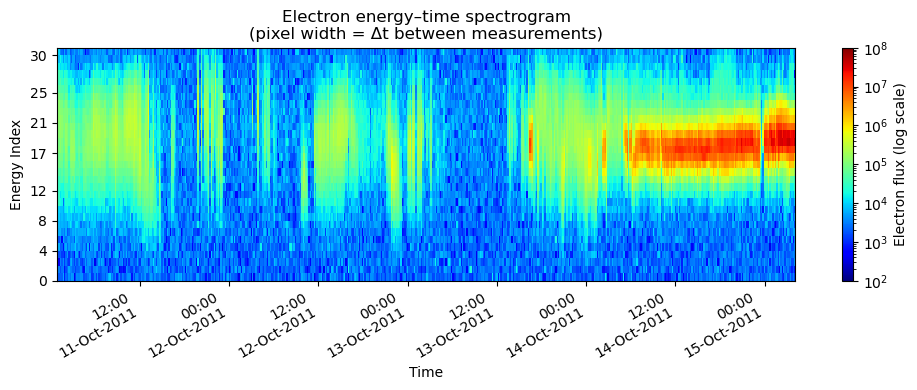

Invalid input. Please enter '1' for magnetotail or '2' for magnetosheath.


In [22]:
testing_dataset.set_regions_for_sections()

In [108]:
dataset.get_session_info()

[{'id': 'session_0000',
  'start_time': '2011-08-14 00:00:00',
  'end_time': '2011-08-15 23:59:00',
  'num_timestamps': 280,
  'variables': ['B_electron_avgtemp',
   'B_electron_density',
   'B_electron_eflux',
   'B_electron_velocity_gsm',
   'B_electron_vthermal',
   'B_ion_avgtemp',
   'B_ion_density',
   'B_ion_eflux',
   'B_ion_velocity_gsm',
   'B_ion_vthermal',
   'B_magnetic_field_gsm',
   'times']},
 {'id': 'session_0001',
  'start_time': '2011-11-12 00:00:00',
  'end_time': '2011-11-14 23:59:00',
  'num_timestamps': 406,
  'variables': ['B_electron_avgtemp',
   'B_electron_density',
   'B_electron_eflux',
   'B_electron_velocity_gsm',
   'B_electron_vthermal',
   'B_ion_avgtemp',
   'B_ion_density',
   'B_ion_eflux',
   'B_ion_velocity_gsm',
   'B_ion_vthermal',
   'B_magnetic_field_gsm',
   'times']},
 {'id': 'session_0002',
  'start_time': '2011-08-16 00:00:00',
  'end_time': '2011-08-18 00:00:00',
  'num_timestamps': 314,
  'variables': ['B_electron_avgtemp',
   'B_electro

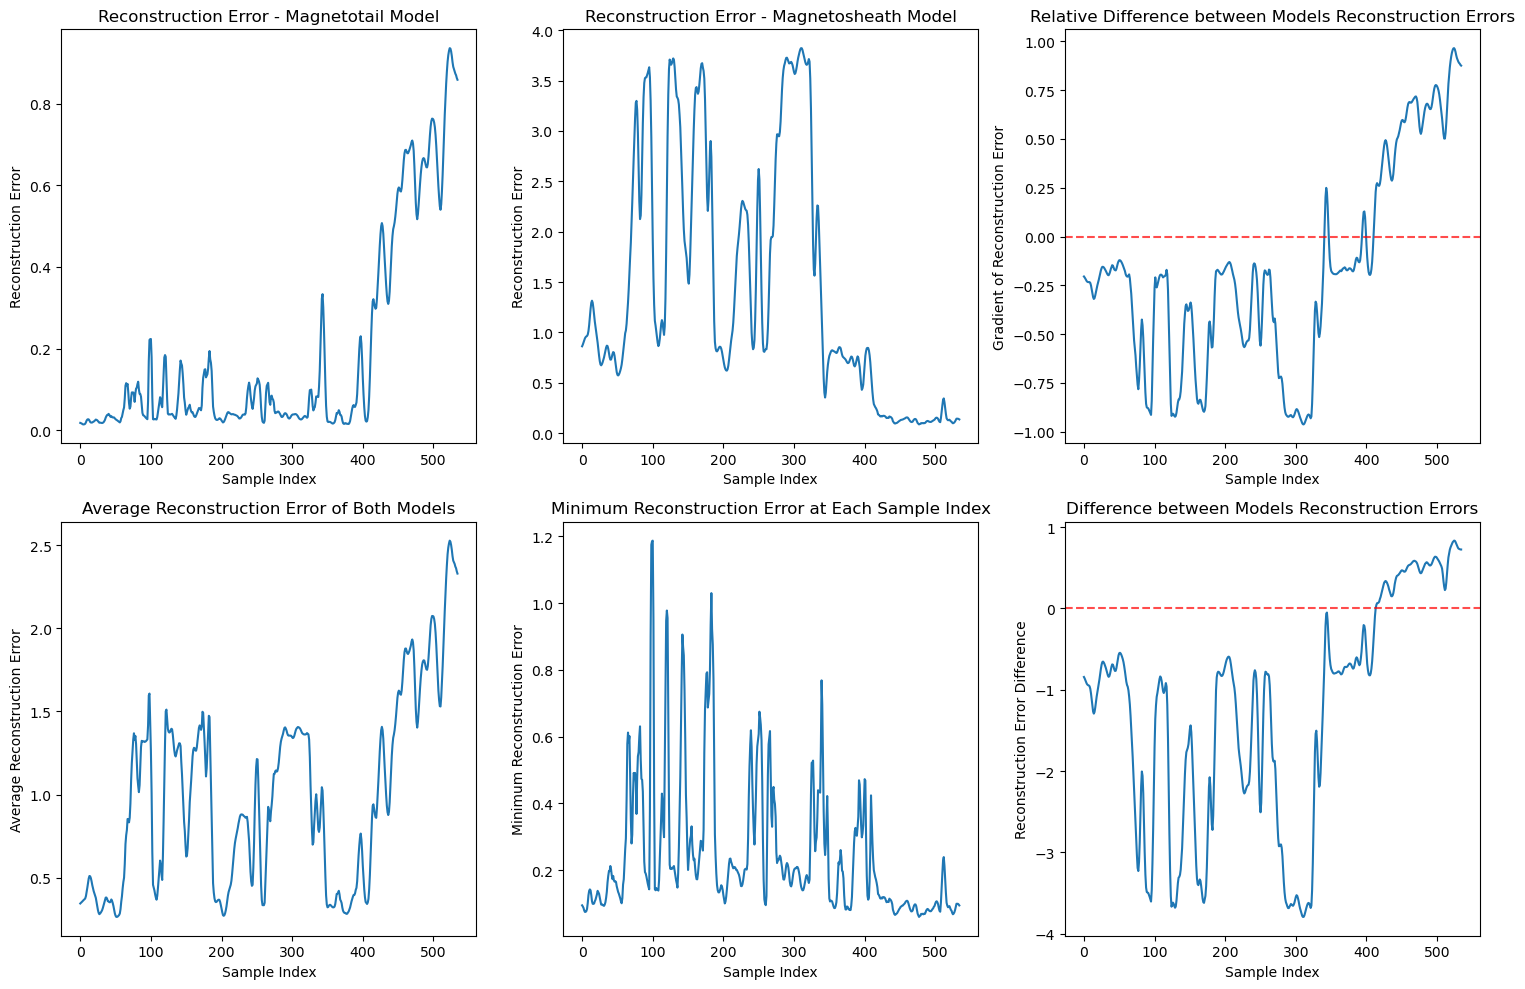

(tensor([0.0177, 0.0171, 0.0163, 0.0148, 0.0140, 0.0140, 0.0145, 0.0157, 0.0191,
         0.0234, 0.0259, 0.0267, 0.0262, 0.0235, 0.0201, 0.0186, 0.0185, 0.0188,
         0.0200, 0.0209, 0.0224, 0.0239, 0.0259, 0.0251, 0.0243, 0.0220, 0.0201,
         0.0182, 0.0184, 0.0180, 0.0177, 0.0174, 0.0181, 0.0194, 0.0220, 0.0254,
         0.0306, 0.0343, 0.0370, 0.0371, 0.0399, 0.0380, 0.0346, 0.0325, 0.0343,
         0.0319, 0.0311, 0.0313, 0.0310, 0.0285, 0.0269, 0.0253, 0.0243, 0.0230,
         0.0217, 0.0200, 0.0189, 0.0218, 0.0295, 0.0325, 0.0412, 0.0492, 0.0556,
         0.0776, 0.1088, 0.1152, 0.1098, 0.1132, 0.0917, 0.0666, 0.0526, 0.0575,
         0.0790, 0.0924, 0.0915, 0.0924, 0.0866, 0.0693, 0.0902, 0.1018, 0.1042,
         0.1129, 0.1187, 0.0999, 0.0891, 0.0885, 0.0818, 0.0625, 0.0423, 0.0364,
         0.0357, 0.0341, 0.0320, 0.0299, 0.0282, 0.0268, 0.0713, 0.1694, 0.2211,
         0.2231, 0.2235, 0.1792, 0.0794, 0.0268, 0.0262, 0.0275, 0.0267, 0.0266,
         0.0260, 0.0321, 0.0

In [134]:
MAE_transformer.plot_results(test_samples)

# Proof cause i could not believe it

In [123]:
from datetime import datetime

for section_key in trainable_samples.keys():
    times_tensor = trainable_samples[section_key]['times']
    first_time_ns = times_tensor[0].item()  # Get first timestamp in nanoseconds
    first_time_s = first_time_ns / 1e9  # Convert to seconds
    dt = datetime.fromtimestamp(first_time_s)
    print(f"Section {section_key}: {dt}")

Section section_000: 2011-08-14 02:00:52.837745
Section section_001: 2011-08-15 20:39:32.148773
Section section_002: 2011-11-12 00:58:56.508330
Section section_003: 2011-11-12 07:44:23.203094
Section section_004: 2011-11-13 05:36:55.723434
Section section_005: 2011-11-14 00:35:22.883310
Section section_006: 2011-08-16 02:00:13.602259
Section section_007: 2011-08-16 04:35:59.451095
Section section_008: 2011-08-17 11:03:55.735966
Section section_009: 2011-11-09 01:01:04.081035
Section section_010: 2011-09-13 23:09:15.241497
Section section_011: 2011-09-14 16:22:20.209512
Section section_012: 2011-09-15 02:33:56.410089
Section section_013: 2012-02-08 00:59:56.853354
Section section_014: 2012-02-09 15:06:00.928920
Section section_015: 2012-05-02 01:59:58.230397
Section section_016: 2012-05-04 09:05:22.640257
Section section_017: 2012-11-27 01:08:22.327083
Section section_018: 2012-11-30 03:00:46.702051
Section section_019: 2012-11-30 13:05:30.585768
Section section_020: 2011-12-08 05:00:07